# Gaussian Naive Bayes - Lab

## Introduction

Now that you've seen how to employ multinomial Bayes for classification, its time to practice implementing the process yourself. You'll also get a chance to investigate the impacts of using true probabilities under the probability density function as opposed to the point estimate on the curve itself.

## Objectives

You will be able to:

* Independently code and implement the Gaussian Naive Bayes algorithm

## Load the dataset

To get started, load the dataset stored in the file `'heart.csv'`. The dataset contains various measurements regarding patients and a `'target'` feature indicating whether or not they have heart disease. You'll be building a GNB classifier to help determine whether future patients do or do not have heart disease. As reference, this dataset was taken from Kaggle. You can see the original data post here: https://www.kaggle.com/ronitf/heart-disease-uci.

In [1]:
# Your code here 
# Load the dataset
import pandas as pd

df = pd.read_csv('heart.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Define the problem

As discussed, the dataset contains various patient measurements along with a `'target'` variable indicating whether or not the individual has heart disease. Define `X` and `y` below: 

In [2]:
# Your code here
target = 'target'

Y = df[[target]]
print(f"Y has cols: {Y.columns}")
print(f"'{target}' value counts:\n{Y[target].value_counts()}\n")
X = df.drop([target], axis=1)
print(f"X has cols: {X.columns}")

Y has cols: Index(['target'], dtype='object')
'target' value counts:
1    165
0    138
Name: target, dtype: int64

X has cols: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')


## Perform a Train-test split

While not demonstrated in the previous lesson, you've seen from your work with regression that an appropriate methodology to determine how well your algorithm will generalize to new data is to perform a train-test split. 

> Note: Set `random_state` to 22 and `test_size` to 0.25 to have your results match those of the solution branch provided.

In [3]:
# Your code here
# Perform a train-test split

from sklearn.model_selection import train_test_split

def test_train_split(df, target, test_size, random_state=None):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state) if random_state is not None else train_test_split(X, Y, test_size=test_size)
    return (pd.concat([X_train, Y_train], axis=1, join='inner'), pd.concat([X_test, Y_test], axis=1, join='inner'))

In [4]:
df_train, df_test = test_train_split(df, target, test_size=0.25, random_state=22)
df_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
110,64,0,0,180,325,0,1,154,1,0.0,2,0,2,1
230,47,1,2,108,243,0,1,152,0,0.0,2,0,2,0
124,39,0,2,94,199,0,1,179,0,0.0,2,0,2,1
77,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
196,46,1,2,150,231,0,1,147,0,3.6,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,58,0,3,150,283,1,0,162,0,1.0,2,0,2,1
146,44,0,2,118,242,0,1,149,0,0.3,1,1,2,1
84,42,0,0,102,265,0,0,122,0,0.6,1,0,2,1
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0


## Calculate the mean & standard deviation of each feature for each class in the training set

Now, calculate the mean and standard deviation for each feature within each of the target class groups. This will serve as your a priori distribution estimate to determine the posterior likelihood of an observation belonging to one class versus the other.

In [5]:
# Your code here 
# Calculate the mean and standard deviation for each feature within each class for the training set

def get_aggs(df, groupby):
    return df.groupby(groupby).agg(['mean', 'std'])

In [6]:
aggs_train = get_aggs(df_train, target)
aggs_train

age                 sex                  cp            \
             mean       std      mean       std      mean       std   
target                                                                
0       57.281553  8.009085  0.796117  0.404853  0.466019  0.916253   
1       52.322581  9.995567  0.564516  0.497832  1.427419  0.972578   

          trestbps                   chol             ...     exang            \
              mean        std        mean        std  ...      mean       std   
target                                                ...                       
0       134.067961  18.919469  251.543689  52.341596  ...  0.543689  0.500523   
1       129.137097  16.589415  240.516129  46.683240  ...  0.161290  0.369291   

         oldpeak               slope                  ca                thal  \
            mean       std      mean       std      mean       std      mean   
target                                                                         
0       1.600971  1.310253  1.184466  0.555676  1.213592  1.025656  2.582524   
1       0.592742  0.749544  1.580645  0.612827  0.354839  0.818422  2.072581   

                  
             std  
target            
0       0.602678  
1       0.444906  

[2 rows x 26 columns]

In [7]:
aggs_test = get_aggs(df_test, target)
aggs_test

age                 sex                  cp            \
            mean       std      mean       std      mean       std   
target                                                               
0       54.60000  7.581712  0.914286  0.284029  0.514286  0.886879   
1       53.02439  8.147048  0.560976  0.502433  1.219512  0.880687   

          trestbps                   chol             ...     exang            \
              mean        std        mean        std  ...      mean       std   
target                                                ...                       
0       135.371429  18.396108  249.742857  40.417194  ...  0.571429  0.502096   
1       129.804878  15.012028  247.414634  70.854420  ...  0.073171  0.263652   

         oldpeak               slope                  ca                thal  \
            mean       std      mean       std      mean       std      mean   
target                                                                         
0       1.540000  1.288456  1.114286  0.582663  1.028571  1.097744  2.428571   
1       0.553659  0.877524  1.634146  0.536474  0.390244  0.945464  2.268293   

                  
             std  
target            
0       0.884032  
1       0.501218  

[2 rows x 26 columns]

## Define a function to calculate the point estimate for the conditional probability of a feature value for a given class

Recall that the point estimate is given by the probability density function of the normal distribution:  

 $$ \large P(x_i|y) = \frac{1}{\sqrt{2 \pi \sigma_i^2}}e^{\frac{-(x-\mu_i)^2}{2\sigma_i^2}}$$

> Note: Feel free to use the built-in function from SciPy to do this as demonstrated in the lesson. Alternatively, take the time to code the above formula from scratch.

In [8]:
# Your code here
import numpy as np

def cond_prob(df, feat, target, class_, aggs, obs_row=None):
    mu = aggs[feat]['mean'][class_]
    sd = aggs[feat]['std'][class_]
    
    sd_sq_x_2 = 2 * sd**2
    coeff = 1/np.sqrt(sd_sq_x_2 * np.pi)
    exp = np.e**((-(df[feat]-mu)**2)/sd_sq_x_2)
    df_cp = coeff * exp
    return df_cp if obs_row is None else df_cp.iloc[obs_row]

In [9]:
from scipy import stats

def p_x_given_class(df, feat, target, class_, aggs, obs_row):
    mu = aggs[feat]['mean'][class_]
    std = aggs[feat]['std'][class_]
    
    # A single observation
    obs_row = df.iloc[obs_row]
    obs = obs_row[feat] 
    
    return stats.norm.pdf(obs, loc=mu, scale=std)

In [10]:
s_output = "condition probability (computed {}) of '{}' given '{}'=={} of row {} is: {}"
feat = 'age'
class_ = 0
row_idx = 0

cp_manual = cond_prob(df_train, feat, target, class_=class_, aggs=aggs_train, obs_row=row_idx)
cp_using_stats = p_x_given_class(df_train, feat, target, class_=class_, aggs=aggs_train, obs_row=row_idx)

print(s_output.format('manually', feat, target, class_, row_idx, cp_manual))
print(s_output.format('using stats.norm.pdf()', feat, target, class_, row_idx, cp_using_stats))

condition probability (computed manually) of 'age' given 'target'==0 of row 0 is: 0.03503693812383461
condition probability (computed using stats.norm.pdf()) of 'age' given 'target'==0 of row 0 is: 0.035036938123834606


## Define a prediction function 

Define a prediction function that will return a predicted class value for a particular observation. To do this, calculate the point estimates for each of the features using your function above. Then, take the product of these point estimates for a given class and multiply it by the probability of that particular class. Take the class associated with the largest probability output from these calculations as your prediction.

In [11]:
# Your code here
def predict_class(df, target, row, aggs, f_cp=p_x_given_class):
    c_probs = []
    classes = sorted(df[target].unique())
    for c in classes:
        p = len(df[df[target]==c])/len(df[target])
        X = df.drop([target], axis=1)
        for feat in X.columns:
            p *= f_cp(df, feat, target, class_=c, aggs=aggs, obs_row=row)
        c_probs.append(p)
    return classes[np.argmax(c_probs)]

## Apply your prediction function to the training and test sets

In [12]:
# Your code here
row = 0
df_train.iloc[row]

age          64.0
sex           0.0
cp            0.0
trestbps    180.0
chol        325.0
fbs           0.0
restecg       1.0
thalach     154.0
exang         1.0
oldpeak       0.0
slope         2.0
ca            0.0
thal          2.0
target        1.0
Name: 110, dtype: float64

In [14]:
pc = predict_class(df_train, target, row, aggs_train)
print(f"predicted class of row {row} is (using using stats.norm.pdf()): {pc}; predicted==actual? {pc==df_train.iloc[row][target]}\n")

pc_manual = predict_class(df_train, target, row, aggs_train, f_cp=cond_prob)
print(f"predicted class of row {row} is (computed manually): {pc_manual}; predicted==actual? {pc_manual==df_train.iloc[row][target]}\n")

predicted class of row 0 is (using using stats.norm.pdf()): 0; predicted==actual? False

predicted class of row 0 is (computed manually): 0; predicted==actual? False



## Calculate the training and test accuracy

In [13]:
# Your code here
print("accuracy on training set using stats.norm.pdf() of predicted==observed:")
df_train_using_stats = df_train.copy()
df_train_using_stats['Predictions'] = [predict_class(df_train_using_stats, target, row, aggs_train) for row in range(len(df_train_using_stats))]
df_train_using_stats['Correct?'] = df_train_using_stats[target] == df_train_using_stats['Predictions']
df_train_using_stats['Correct?'].value_counts(normalize=True)

accuracy on training set using stats.norm.pdf() of predicted==observed:


True     0.85022
False    0.14978
Name: Correct?, dtype: float64

In [15]:
print("accuracy on test set using stats.norm.pdf() of predicted==observed:")
df_test_using_stats = df_test.copy()
df_test_using_stats['Predictions'] = [predict_class(df_test_using_stats, target, row, aggs_test) for row in range(len(df_test_using_stats))]
df_test_using_stats['Correct?'] = df_test_using_stats[target] == df_test_using_stats['Predictions']
df_test_using_stats['Correct?'].value_counts(normalize=True)

accuracy on test set using stats.norm.pdf() of predicted==observed:


True     0.802632
False    0.197368
Name: Correct?, dtype: float64

In [17]:
print("accuracy on training set of predicted==observed computed manually:")
df_train_comp_manually = df_train.copy()
df_train_comp_manually['Predictions'] = [predict_class(df_train_comp_manually, target, row, aggs_train, f_cp=cond_prob) for row in range(len(df_train_comp_manually))]
df_train_comp_manually['Correct?'] = df_train_comp_manually[target] == df_train_comp_manually['Predictions']
df_train_comp_manually['Correct?'].value_counts(normalize=True)

accuracy on training set of predicted==observed computed manually:


True     0.85022
False    0.14978
Name: Correct?, dtype: float64

In [16]:
print("accuracy on test set of predicted==observed computed manually:")
df_test_comp_manually = df_test.copy()
df_test_comp_manually['Predictions'] = [predict_class(df_test_comp_manually, target, row, aggs_test, f_cp=cond_prob) for row in range(len(df_test_comp_manually))]
df_test_comp_manually['Correct?'] = df_test_comp_manually[target] == df_test_comp_manually['Predictions']
df_test_comp_manually['Correct?'].value_counts(normalize=True)

accuracy on test set of predicted==observed computed manually:


True     0.802632
False    0.197368
Name: Correct?, dtype: float64

## Level up (Optional)

### Adapting point estimates for the conditional probability into true probability estimates

As discussed, the point estimate from the probability density function is not a true probability measurement. Recall that the area under a probability density function is 1, representing the total probability of all possible outcomes. Accordingly, to determine the probability of a feature measurement occurring, you would need to find the area under some portion of the PDF. Determining appropriate bounds for this area however, is a bit tricky and arbitrary. For example, when generating a class prediction, you would want to know the probability of a patient having a resting blood pressure of 145 given that they had heart disease versus the probability of having a resting blood pressure of 145 given that the did not have heart disease. Previously, you've simply used the point where x=145 on the PDF curve to do this. However, the probability of any single point is actually 0. To calculate the actual probability, you would have to create a range around the observed value such as "what is the probability of having a resting blood pressure between 144 and 146 inclusive?" Alternatively, you could narrow the range and rewrite the problem as "what is the probability of having a resting blood pressure between 144.5 and 145.5?" Since defining these bounds is arbitrary, a potentially interesting research question is how various band methods might impact output predictions and the overall accuracy of the algorithm.


## Rewriting the conditional probability formula

Rewrite your conditional probability formula above to take a feature observation, a given class, and a range width and calculate the actual probability beneath the PDF curve of an observation falling within the range of the given width centered at the given observation value. For example, taking the previous example of resting blood pressure, you might calculate the probability of having a resting blood pressure within 1bp of 145 given that a patient has heart disease. In this case, the range width would be 2bp (144bp to 146bp) and the corresponding area under the PDF curve for the normal distribution would look like this:  

<img src="images/pdf_integral.png">

With that, write such a function below: 

In [18]:
def p_band_x_given_class_rw(df, feat, target, class_, aggs, range_width_std, obs_row):
    # Your code here
    mu = aggs[feat]['mean'][class_]
    std = aggs[feat]['std'][class_]
    delta_std = range_width_std * std/2
    #print(f"delta_std: {delta_std}")
    
    obs = df.iloc[obs_row][feat]
    x_lb = obs-delta_std
    #print(f"x_lb: {x_lb}")
    area_from_x_lb = stats.norm.cdf(x_lb, loc=mu, scale=std)
    #print(f"y_lb: {y_lb}")
    x_ub = obs+delta_std
    #print(f"x_ub: {x_ub}")
    area_from_x_ub = stats.norm.cdf(x_ub, loc=mu, scale=std)
    #print(f"y_ub: {y_ub}")
    
    return area_from_x_ub - area_from_x_lb

## Update the prediction function

Now, update the `predict_class()` function to use this new conditional probability function. Be sure that you can pass in the range width variable to this wrapper function.

In [19]:
# Your code here
# Update the prediction function
def predict_class(df, target, row, aggs, f_cp=p_x_given_class, f_cp_args=None):
    c_probs = []
    classes = sorted(df[target].unique())
    for c in classes:
        p = len(df[df[target]==c])/len(df[target])
        X = df.drop([target], axis=1)
        for feat in X.columns:
            if f_cp is p_band_x_given_class_rw:
                p *= f_cp(df, feat, target, class_=c, aggs=aggs, range_width_std=f_cp_args, obs_row=row)
            else:
                p *= f_cp(df, feat, target, class_=c, aggs=aggs, obs_row=row)
        c_probs.append(p)
    #print(c_probs)
    return classes[np.argmax(c_probs)]

## Experiment with the impact of various range-widths

Finally, write a `for` loop to measure the impact of varying range-widths on the classifier's test and train accuracy. Iterate over various range-widths from 0.1 standard deviations to 2 standard deviations. For each of these, store the associated test and train accuracies. Finally, plot these on a graph. The x-axis should be the associated range-width (expressed in standard deviations; each feature will have a unique width applicable to the specific scale). The y-axis will be the associated accuracy. Be sure to include a legend for train accuracy versus test accuracy.

_Note:_ ⏰ _Expect your code to take over two minutes to run._

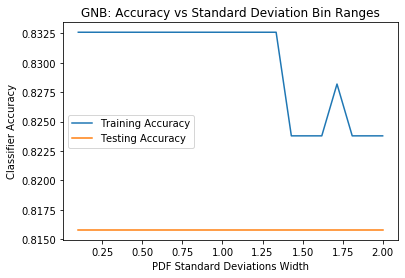

In [20]:
# Your code here

#credit: I adapted this code from the solution
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import HTML

train_accs = []
test_accs = []
range_stds = np.linspace(.1, 2, num=21)
n = 0
n_cap=5
max_rows_to_print=10
for range_std in range_stds:
    y_hat_train = [predict_class(df_train, target, row, aggs_train, f_cp=p_band_x_given_class_rw, f_cp_args=range_std) for row in range(len(df_train))]
    y_hat_test = [predict_class(df_test, target, row, aggs_test, f_cp=p_band_x_given_class_rw, f_cp_args=range_std) for row in range(len(df_test))]
    
    df_train_copy = df_train.copy()
    df_train_copy['Predictions'] = y_hat_train
    df_train_copy['Correct?'] = df_train_copy[target] == df_train_copy['Predictions']
    #display(HTML(df_train_copy.head(max_rows_to_print).to_html()))
    df_train_copy_value_counts = df_train_copy['Correct?'].value_counts(normalize=True)
    #print(f"df_train_copy_value_counts for range_std=={range_std}:\n{df_train_copy_value_counts}\n")
    
    lst_df_train_copy_value_counts = sorted(df_train_copy_value_counts.tolist(), reverse=True)
    train_accs.append(lst_df_train_copy_value_counts[0])
    
    df_test_copy = df_test.copy()
    df_test_copy['Predictions'] = y_hat_test
    df_test_copy['Correct?'] = df_test_copy[target] == df_test_copy['Predictions']
    #display(HTML(df_test_copy.head(max_rows_to_print).to_html()))
    df_test_copy_value_counts = df_test_copy['Correct?'].value_counts(normalize=True)
    #print(f"df_test_copy_value_counts for range_std=={range_std}:\n{df_test_copy_value_counts}\n")
    
    lst_df_test_copy_value_counts = sorted(df_test_copy_value_counts.tolist(), reverse=True)
    test_accs.append(lst_df_test_copy_value_counts[0])
    
#     print()
#     n += 1
#     if n==n_cap:
#         break
    
plt.plot(range_stds, train_accs, label='Training Accuracy')
plt.plot(range_stds, test_accs, label='Testing Accuracy')
plt.title('GNB: Accuracy vs Standard Deviation Bin Ranges')
plt.ylabel('Classifier Accuracy')
plt.xlabel('PDF Standard Deviations Width')
plt.legend();

> Comment: Not a wild difference from our point estimates obtained by using points from the PDF itself, but there is some impact. **Interestingly, these graphs will differ substantially in shape depending on the initial train-test split used.** The recommendation would be to use the point estimates from the PDF itself, or a modest band-width size.

## Appendix: Plotting PDFs and probability integrals

Below, feel free to take a look at the code used to generate the PDF graph image above.

In [21]:
temp = df[df['target'] == 1]['trestbps']
aggs = temp.agg(['mean', 'std'])
aggs

mean    129.303030
std      16.169613
Name: trestbps, dtype: float64

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
import scipy.stats as stats
sns.set_style('white')

Probability of Blood Pressure Falling withing Range for the Given Class: 0.03080251623846919


Text(0.5, 0, 'Resting Blood Pressure')

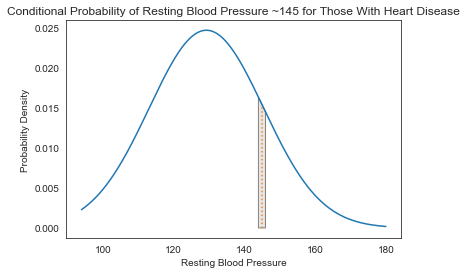

In [23]:
x = np.linspace(temp.min(), temp.max(), num=10**3)
pdf = stats.norm.pdf(x, loc=aggs['mean'], scale=aggs['std'])
xi = 145
width = 2
xi_lower = xi - width/2
xi_upper = xi + width/2

fig, ax = plt.subplots()

plt.plot(x, pdf)

# Make the shaded region
ix = np.linspace(xi_lower, xi_upper)
iy = stats.norm.pdf(ix, loc=aggs['mean'], scale=aggs['std'])
verts = [(xi_lower, 0), *zip(ix, iy), (xi_upper, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly);

plt.plot((145, 145), (0, stats.norm.pdf(145, loc=aggs['mean'], scale=aggs['std'])), linestyle='dotted')
p_area = stats.norm.cdf(xi_upper, loc=aggs['mean'], scale=aggs['std']) - stats.norm.cdf(xi_lower, loc=aggs['mean'], scale=aggs['std'])
print('Probability of Blood Pressure Falling withing Range for the Given Class: {}'.format(p_area))
plt.title('Conditional Probability of Resting Blood Pressure ~145 for Those With Heart Disease')
plt.ylabel('Probability Density')
plt.xlabel('Resting Blood Pressure')

> Comment: See https://matplotlib.org/gallery/showcase/integral.html for further details on plotting shaded integral areas under curves.

## Summary

Well done! In this lab, you implemented the Gaussian Naive Bayes classifier from scratch, and used it to generate classification predictions and validated the accuracy of the model.